In [0]:
!nvidia-smi

Sun Nov 24 21:15:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install gdown
!pip install tensorflow-gpu

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [0]:
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

Downloading...
From: https://drive.google.com/uc?id=10vdMg_RazoIatwrT7azKFX4P02OebU76
To: /content/spx.csv
100% 152k/152k [00:00<00:00, 43.1MB/s]


In [34]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [35]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


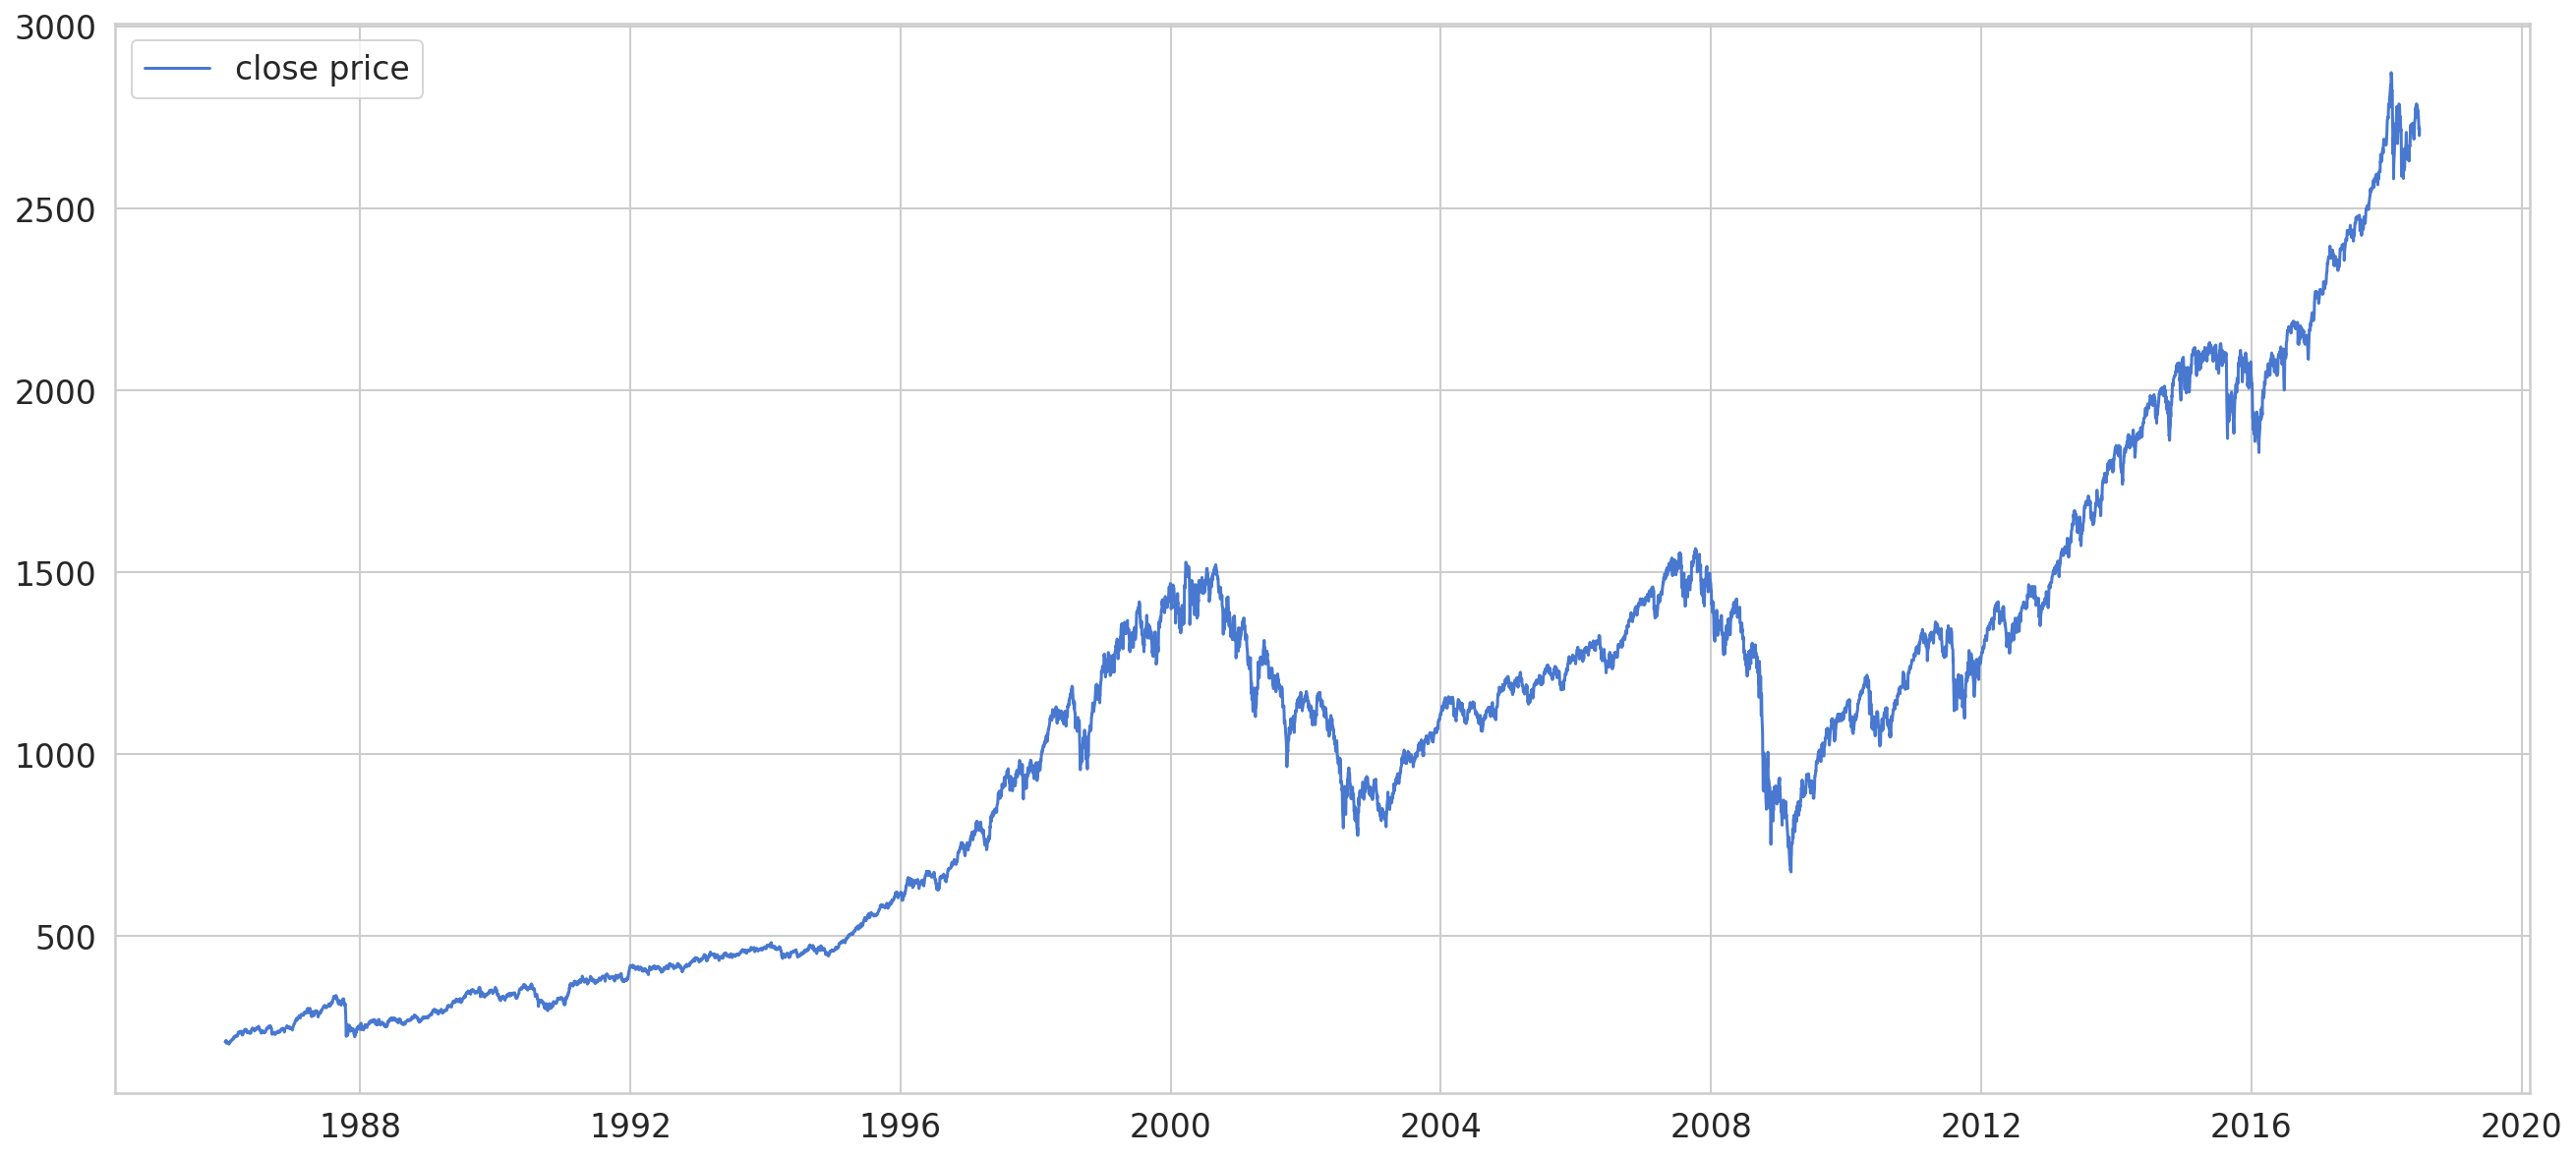

In [36]:
plt.plot(df, label='close price')
plt.legend();

In [37]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/home/michal/.local/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/michal/.local/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [39]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [53]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape, X_train[0])
print(y_train.shape, y_train[1])

(7752, 30, 1) [[-1.4751264 ]
 [-1.47270341]
 [-1.47313541]
 [-1.4672188 ]
 [-1.47816923]
 [-1.48166285]
 [-1.48194459]
 [-1.48051709]
 [-1.48066735]
 [-1.47762452]
 [-1.47591528]
 [-1.47730522]
 [-1.47899568]
 [-1.4822639 ]
 [-1.48658396]
 [-1.48515646]
 [-1.48106179]
 [-1.47925864]
 [-1.47471318]
 [-1.4738116 ]
 [-1.47561475]
 [-1.47101295]
 [-1.46691828]
 [-1.46911587]
 [-1.46879656]
 [-1.46783864]
 [-1.4657913 ]
 [-1.46263578]
 [-1.46323683]
 [-1.46314291]]
(7752,) -1.4560241974723716


In [9]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

2022-02-03 12:13:34.805097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-03 12:13:34.805132: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-03 12:13:34.805156: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tp): /proc/driver/nvidia/version does not exist


In [10]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

2022-02-03 12:13:35.526703: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
218/218 [==============================] - 13s 43ms/step - loss: 0.1691 - val_loss: 0.1827
Epoch 2/10
218/218 [==============================] - 8s 38ms/step - loss: 0.0934 - val_loss: 0.1604
Epoch 3/10
218/218 [==============================] - 8s 38ms/step - loss: 0.0964 - val_loss: 0.1306
Epoch 4/10
218/218 [==============================] - 11s 48ms/step - loss: 0.0879 - val_loss: 0.1044
Epoch 5/10
218/218 [==============================] - 8s 38ms/step - loss: 0.0920 - val_loss: 0.0656
Epoch 6/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1046 - val_loss: 0.0963
Epoch 7/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1005 - val_loss: 0.0755
Epoch 8/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1090 - val_loss: 0.0632
Epoch 9/10
218/218 [==============================] - 8s 38ms/step - loss: 0.1035 - val_loss: 0.1190
Epoch 10/10
218/218 [==============================] - 9s 39ms/step - loss: 0.1130 - val_

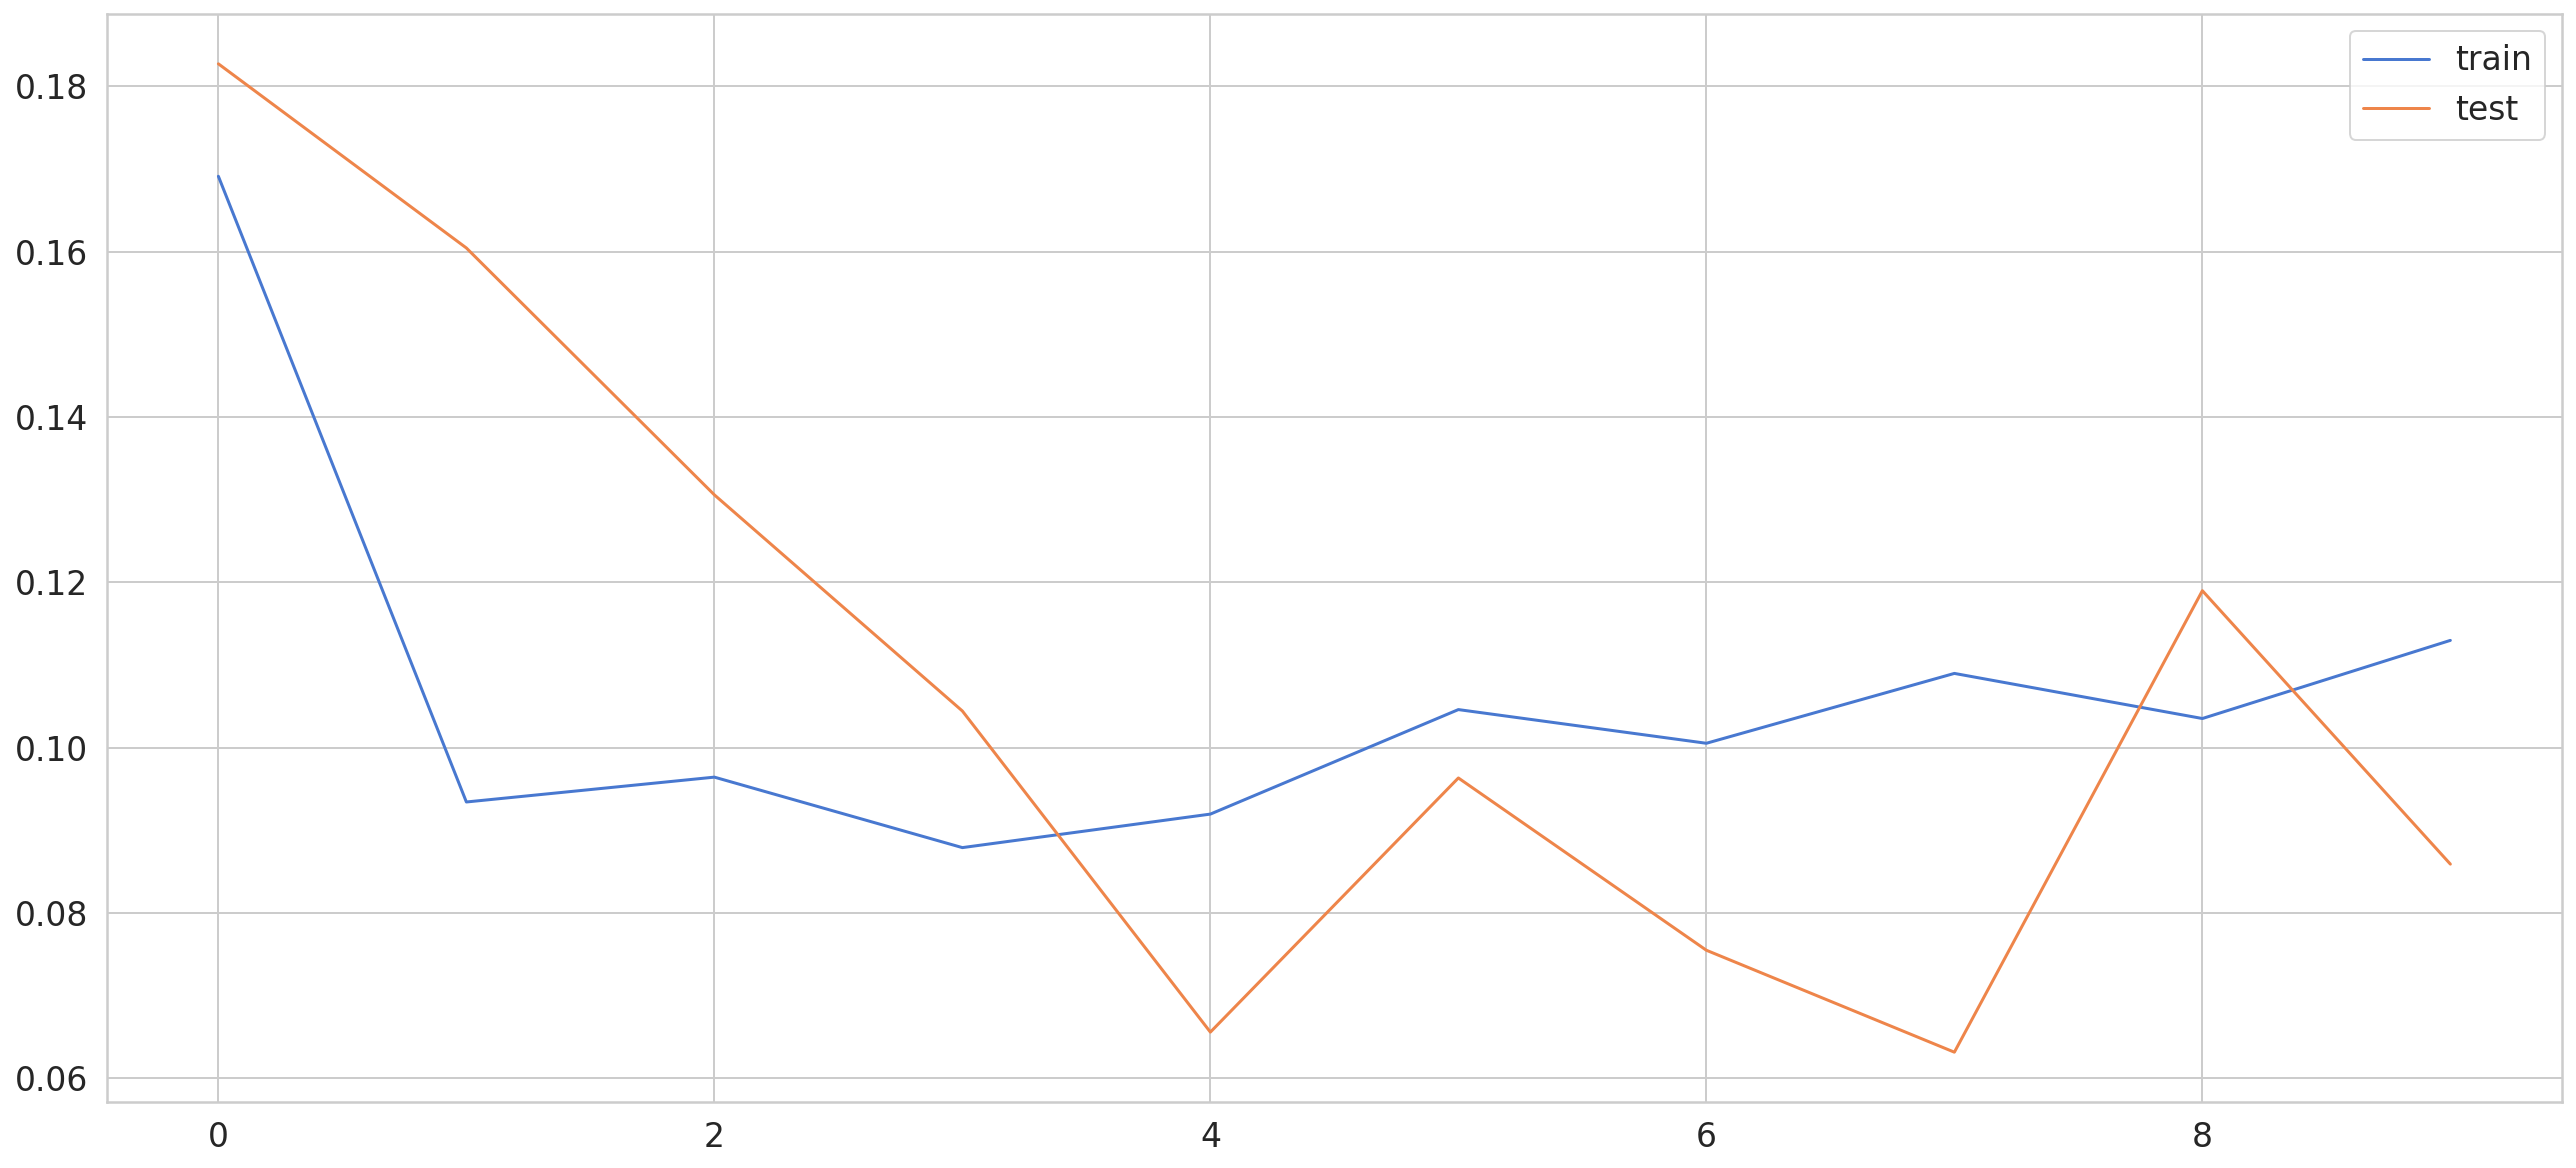

In [11]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [12]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/home/michal/.local/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


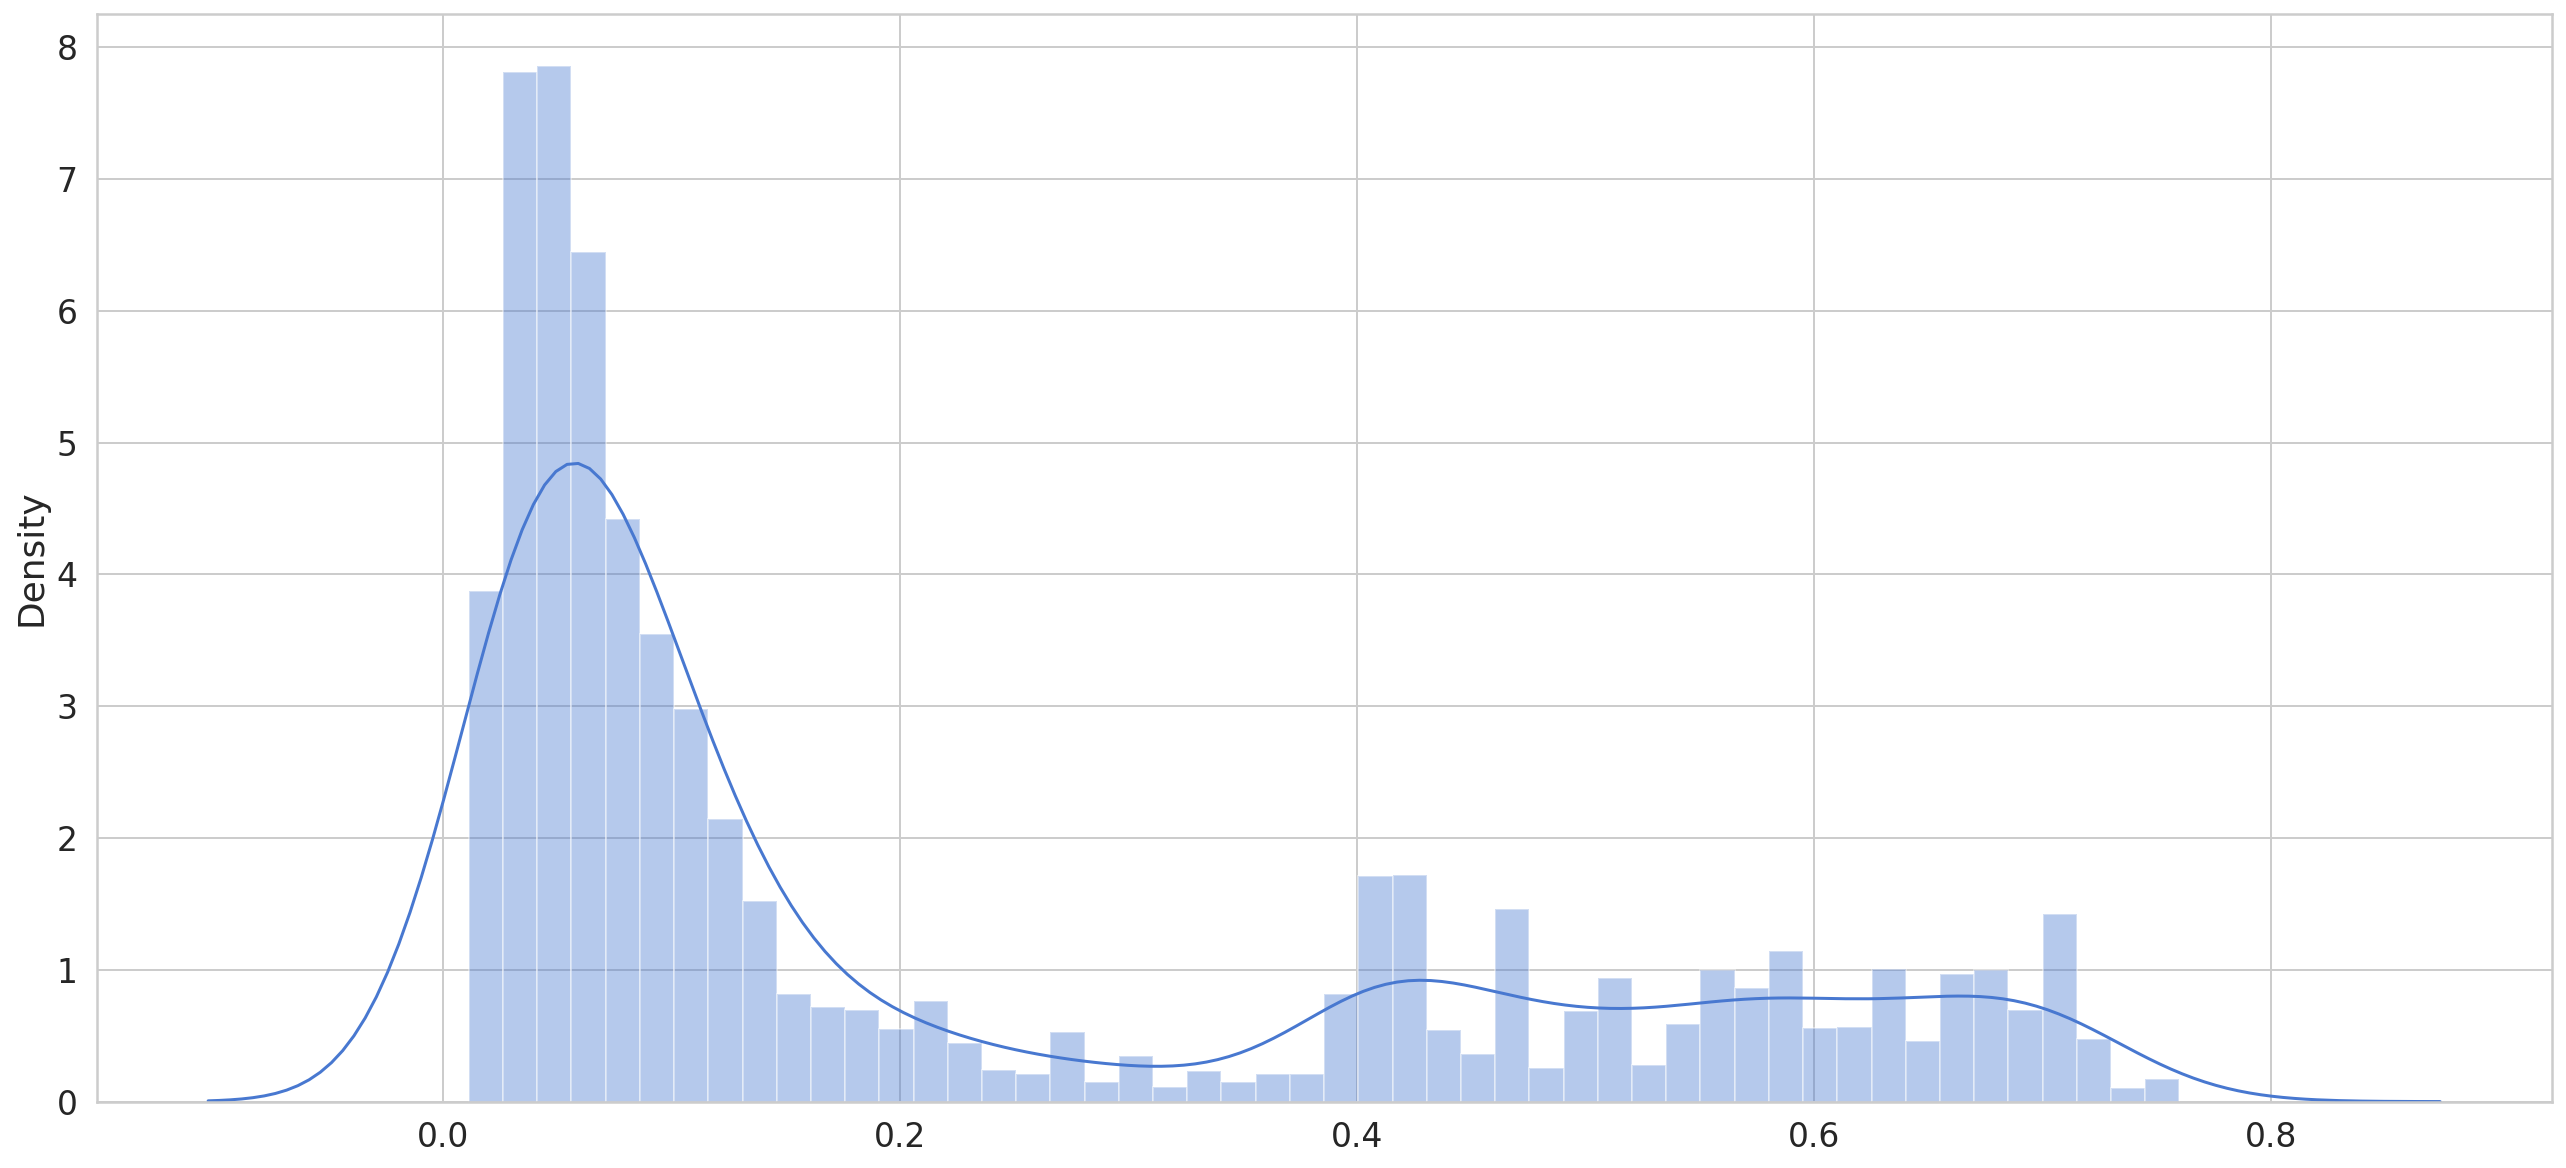

In [13]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [14]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [17]:
THRESHOLD = 0.4

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

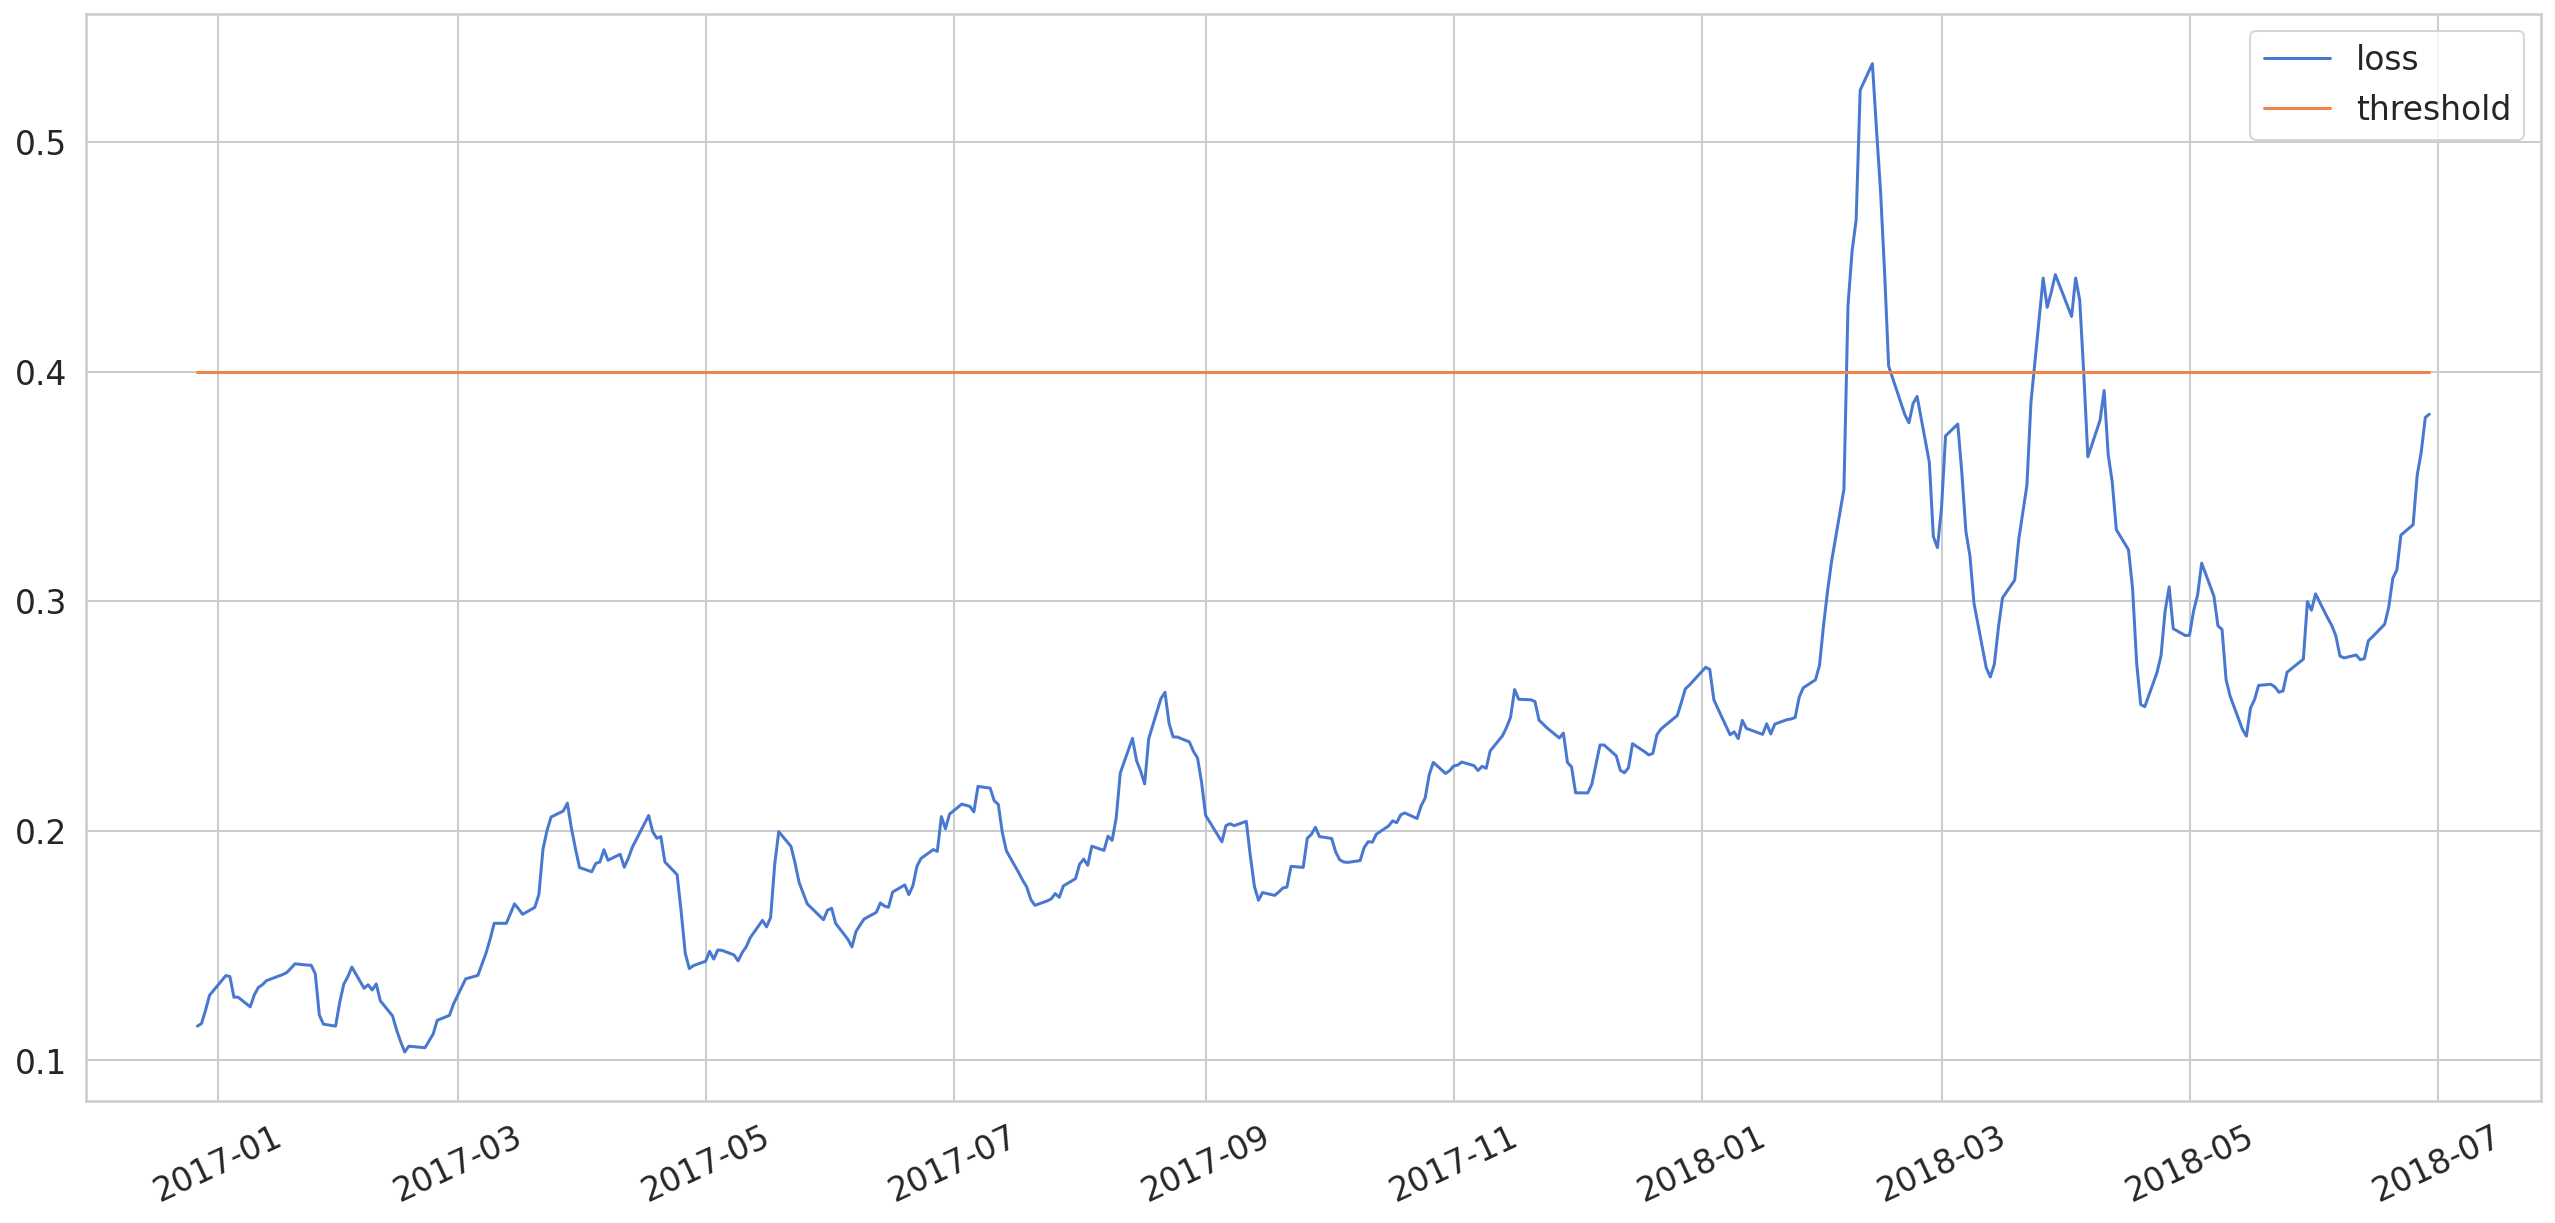

In [18]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [21]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-06,0.428755,0.4,True,3.193456
2018-02-07,0.452400,0.4,True,3.168136
2018-02-08,0.466056,0.4,True,2.979068
2018-02-09,0.522611,0.4,True,3.051476
2018-02-12,0.534135,0.4,True,3.119939


In [31]:
wut = scaler.inverse_transform(anomalies.close.values.reshape(1,-1))
print(wut.reshape(-1))

[2695.14 2681.66 2581.   2619.55 2656.   2662.94 2698.63 2731.2  2732.22
 2658.55 2612.62 2605.   2640.87 2581.88 2614.45 2644.69]


/home/michal/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


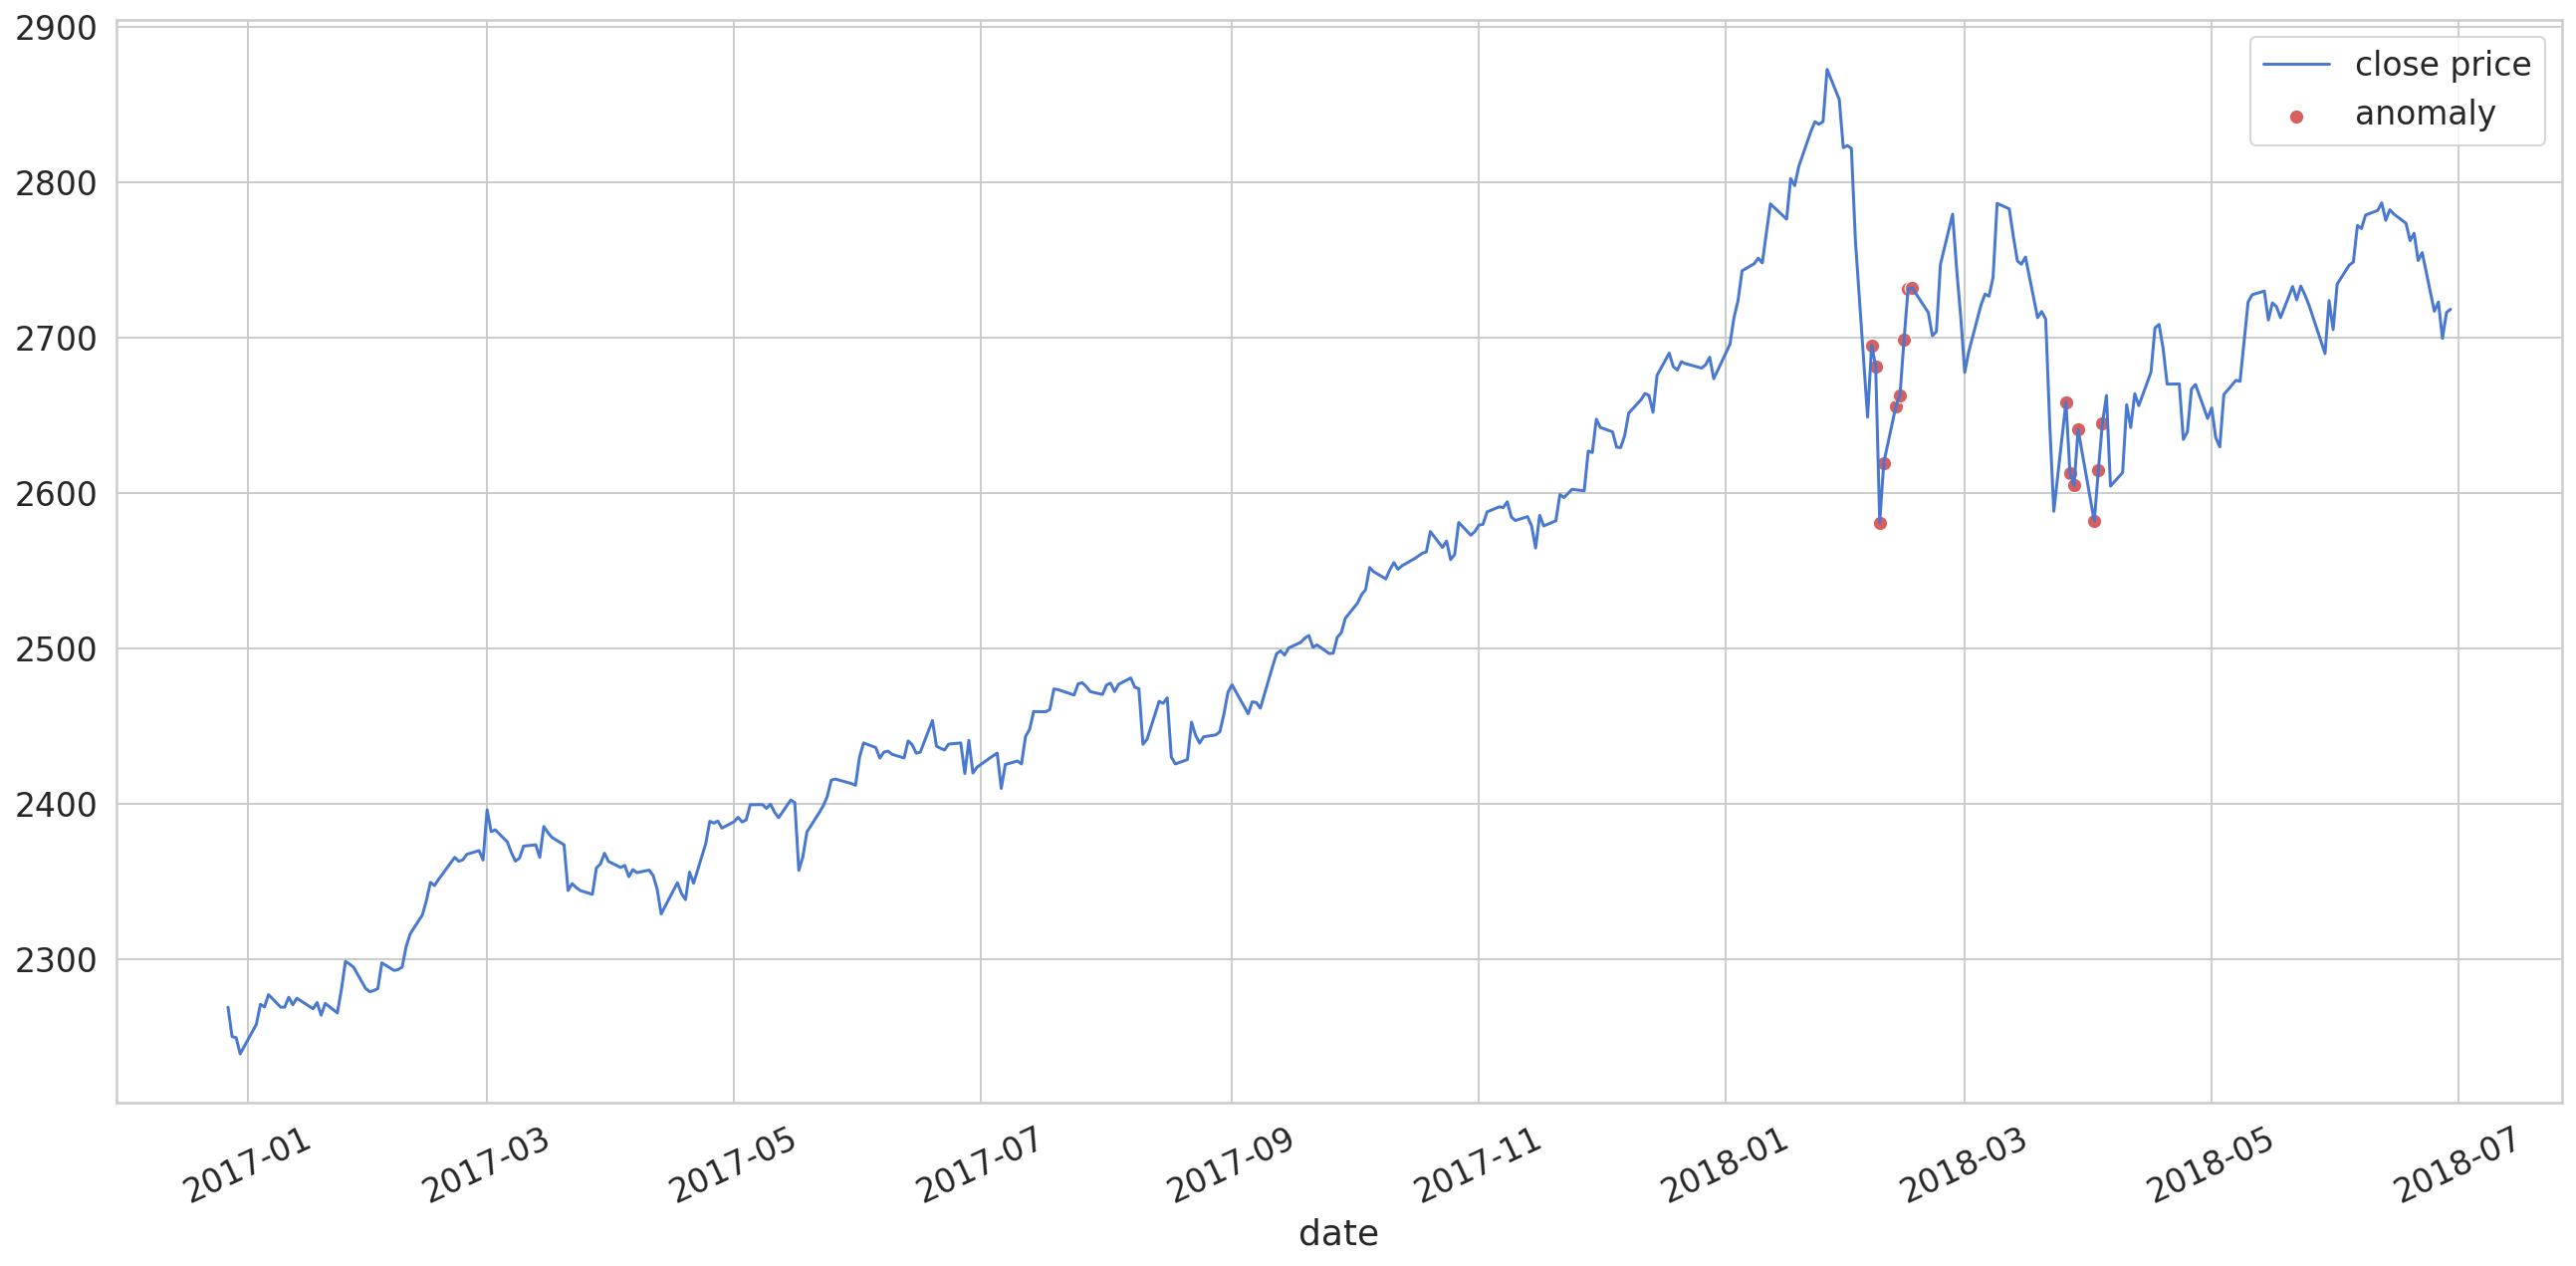

In [32]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close.values.reshape(1,-1)).reshape(-1), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close.values.reshape(1,-1)).reshape(-1),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();